<a href="https://colab.research.google.com/github/SaraaSameer/Freesound-Audio-Tagging/blob/master/Audio_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading Dataset**

In [1]:
! pip install -q kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download freesound-audio-tagging


freesound-audio-tagging.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! unzip freesound-audio-tagging.zip

Streaming output truncated to the last 5000 lines.
  inflating: audio_train/7996c815.wav  
  inflating: audio_train/79a0d2c4.wav  
  inflating: audio_train/79a50c1d.wav  
  inflating: audio_train/79a8dbcc.wav  
  inflating: audio_train/79b29f52.wav  
  inflating: audio_train/79b31a2e.wav  
  inflating: audio_train/79b83450.wav  
  inflating: audio_train/79bb1b55.wav  
  inflating: audio_train/79bc77b2.wav  
  inflating: audio_train/79be82bb.wav  
  inflating: audio_train/79c2afb1.wav  
  inflating: audio_train/79cbc8f6.wav  
  inflating: audio_train/79cc9b98.wav  
  inflating: audio_train/79cf0f4b.wav  
  inflating: audio_train/79d44891.wav  
  inflating: audio_train/79db26c2.wav  
  inflating: audio_train/79e22357.wav  
  inflating: audio_train/79e99e49.wav  
  inflating: audio_train/79f04f95.wav  
  inflating: audio_train/79faa0c4.wav  
  inflating: audio_train/79fd94aa.wav  
  inflating: audio_train/79fdfdb8.wav  
  inflating: audio_train/7a002442.wav  
  inflating: audio_train/7a0c

In [6]:
# from google.colab import files
# files.download('/content/freesound-audio-tagging.zip')

In [7]:
import os, math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb     #gradient boostign for classification

import librosa
import librosa.display     #for working with audio files

from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split

import IPython              #displaying python objects
import IPython.display as ipd

from prettytable import PrettyTable
import random
from tqdm import tqdm_notebook, tqdm_pandas      #add progress bar (for progress_apply())
tqdm_notebook().pandas(smoothing = 0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

**Loading Dataset**


In [8]:
test_df = pd.read_csv('/content/sample_submission.csv')
train_df = pd.read_csv('/content/train.csv')
train_df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [9]:
test_df.head()

,fname,label
0,00063640.wav,Laughter Hi-Hat Flute
1,0013a1db.wav,Laughter Hi-Hat Flute
2,002bb878.wav,Laughter Hi-Hat Flute
3,002d392d.wav,Laughter Hi-Hat Flute
4,00326aa9.wav,Laughter Hi-Hat Flute


**Data Count**

In [10]:
n_train = train_df.shape[0]
n_test = test_df.shape[0]
n_category = train_df['label'].nunique()

print('Number of Training Examples are {}'.format(n_train)) 
print('Number of Testing Examples are {}'.format(n_test)) 
print('Number of Unique Categories are {}'.format(n_category)) 

Number of Training Examples are 9473
Number of Testing Examples are 9400
Number of Unique Categories are 41


**Visualizing Labels Based on Verification**

A lot of labels are not manually verified, this can be another usecase of this project.



Macro Categories are: Instruments, Instruments-continued, Human, Action and others.

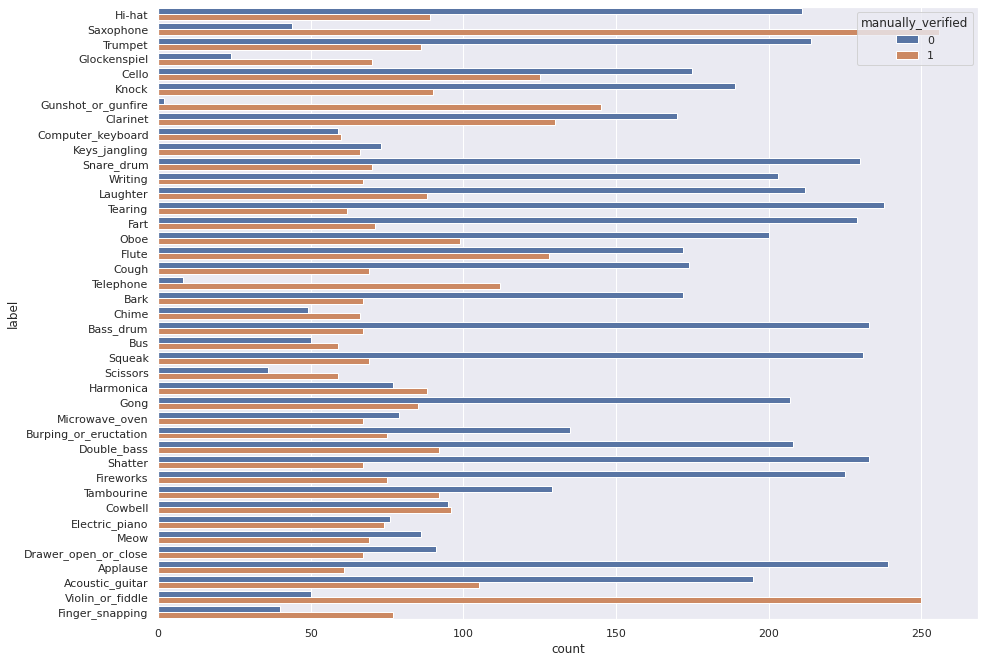

In [43]:
sns.countplot(y=train_df.label , hue= train_df.manually_verified)
sns.set(rc={'figure.figsize':(14.7,11.27)})

In [12]:
def play_audio(wavfile, dset='train'):
  print(wavfile)
  fname = '/content/audio_{}/{}'.format(dset,wavfile)
  IPython.display.display(ipd.Audio(fname))   #displaying audio object

 #loading audio as waveform x and sampling rate as sr
  x,sr = librosa.load(fname)

  plt.figure(figsize=(14,5))
  librosa.display.waveplot(x,sr=sr)   #displaying waves
  
  X = librosa.stft(x)  #time-localized frequency
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(14,5))       
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   #Display a spectrogram/chromagram/cqt/etc.

Saxophone
c8faa3e3.wav


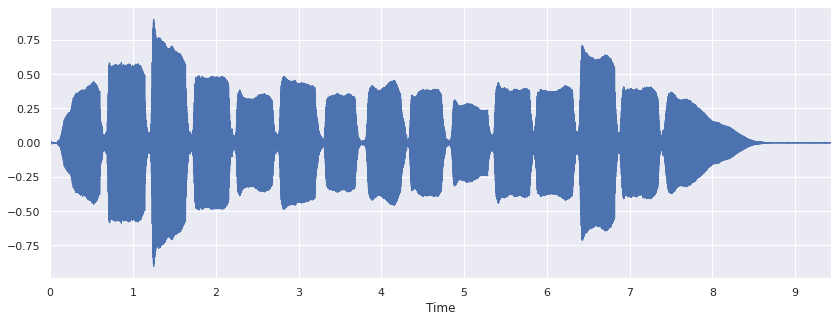

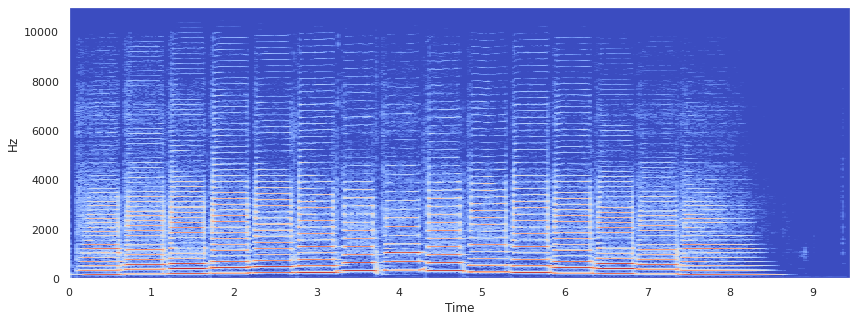

In [13]:
random_int = random.randint(0,n_train)
random_wavfile = train_df.fname.iloc[random_int]
print(train_df.label.iloc[random_int])   # printing label of audio

play_audio(random_wavfile)


**Feature Engineering**


In [14]:
def wav_stats(fname,dset):
  try:
    data, fs= librosa.core.load('/content/audio_{}/{}'.format(dset,fname), sr=None)   #default sr=22050, to preserve auto audio sampling, sr = none
    mean = np.mean(data)
    minimum = np.min(data)
    maximum = np.max(data)
    std = np.std(data)
    length = len(data)
    rms = np.sqrt(np.mean(data**2))
    skewness = skew(data)
    kurt = kurtosis(data)
    return pd.Series([length, mean, minimum, maximum, std, rms, skewness, kurt])
  except ValueError:
    print('Bad file at {}'.format(fname))
    return pd.Series([0,0,0,0,0,0,0,0,])


In [15]:
train_df[['length', 'data_mean', 'data_min', 'data_max', 'data_std', 'data_res','skewness', 'kurtosis']] = \
train_df['fname'].progress_apply(wav_stats, dset= 'train')

  0%|          | 0/9473 [00:00<?, ?it/s]

In [16]:
test_df[['length','data_mean','data_min', 'data_max','data_std','data_res','skewness', 'kurtosis']] = \
test_df['fname'].progress_apply(wav_stats, dset= 'test')

  0%|          | 0/9400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Bad file at 0b0427e2.wav
Bad file at 6ea0099f.wav
Bad file at b39975f5.wav


In [17]:
train_df.head()

,fname,label,manually_verified,length,data_mean,data_min,data_max,data_std,data_res,skewness,kurtosis
0,00044347.wav,Hi-hat,0,617400.0,-0.000028,-0.567657,0.554474,0.036831,0.036831,-0.024415,58.395596
1,001ca53d.wav,Saxophone,1,455112.0,-0.000015,-0.384308,0.479156,0.097552,0.097552,0.817412,1.961728
2,002d256b.wav,Trumpet,0,19404.0,-0.000035,-0.019409,0.021149,0.002002,0.002003,0.008723,25.091358
3,0033e230.wav,Glockenspiel,1,352800.0,-0.000025,-0.254669,0.240540,0.007908,0.007908,-0.019489,45.271655
4,00353774.wav,Cello,1,199332.0,-0.000001,-0.391510,0.361877,0.091730,0.091730,-0.334202,1.349436


In [18]:
test_df.head()

,fname,label,length,data_mean,data_min,data_max,data_std,data_res,skewness,kurtosis
0,00063640.wav,Laughter Hi-Hat Flute,69678.0,-0.000015,-0.393524,0.431305,0.008103,0.008103,2.387373,838.936329
1,0013a1db.wav,Laughter Hi-Hat Flute,36162.0,-0.000030,-0.064880,0.052826,0.010715,0.010715,-0.538347,9.343325
2,002bb878.wav,Laughter Hi-Hat Flute,59094.0,-0.004574,-0.975189,0.976349,0.500644,0.500665,-0.028547,-0.994223
3,002d392d.wav,Laughter Hi-Hat Flute,22050.0,-0.000029,-0.566528,0.627716,0.315848,0.315848,0.024613,-1.350767
4,00326aa9.wav,Laughter Hi-Hat Flute,91728.0,-0.000016,-0.418823,0.480896,0.178595,0.178595,0.141632,0.593945


In [19]:
#testing bad audios (silence audios)
random_wavfile = train_df[(train_df['fname']=='0b0427e2.wav')]
IPython.display.display(ipd.Audio('audio_test/0b0427e2.wav'))

**Box Plot and Bar Plot**

In [20]:
def plot_hist(feature_name, bins=50, log=False):
  data = train_df[feature_name].values
  plt.hist(data, bins=bins, log=log)
  plt.grid()
  plt.show()

def plot_boxplot(feature_name):
  props = dict(linewidth =3)
  train_df.boxplot(column=feature_name, by='label',rot=90, sym='',grid=False, boxprops=props )
  plt.title('{} boxplot'.format(feature_name))
  plt.suptitle('')

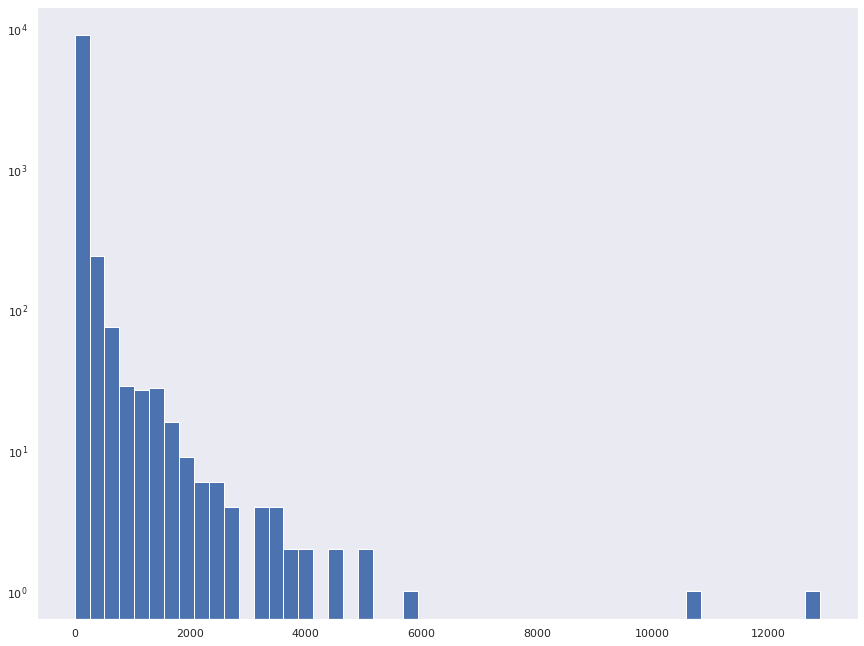

In [21]:
features = 'kurtosis'
plot_hist(features, log=True)

# Most of kurtosis values are close to zero

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


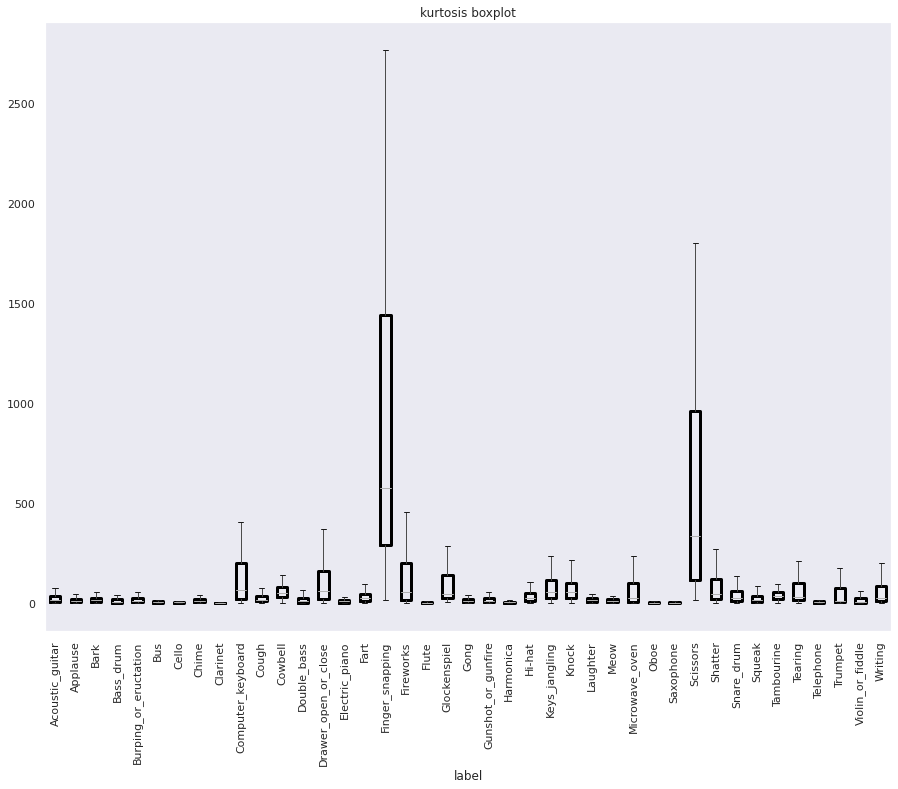

In [22]:
plot_boxplot(features)

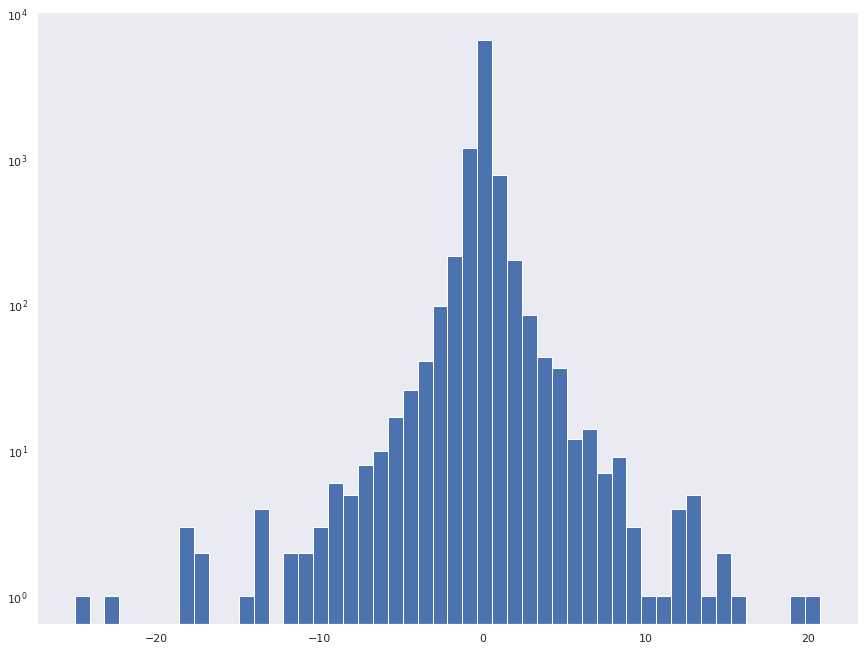

In [23]:
features = 'skewness'
plot_hist(features, log=True)

In [24]:
missing = train_df.isnull().sum()
# print(missing[0:4])   # show missing values of col no 0 to 4
print(missing)

# Finding percentage of missing value
total_cells = np.product(train_df.shape)
percent = (missing.sum() / total_cells)*100
percent 

fname                0
label                0
manually_verified    0
length               0
data_mean            0
data_min             0
data_max             0
data_std             0
data_res             0
skewness             0
kurtosis             0
dtype: int64


0.0

In [25]:
def data_split(train_df, test_df, shuffle=True, test_size=0.25, random_state=0, verbose=True):
  # Get numpy array of X data
  X_train = train_df.drop(['fname','label','manually_verified'], axis=1).values
  X_test = test_df.drop(['fname','label'], axis=1).values
  feature_names = list(test_df.drop(['fname','label'], axis=1).columns.values)

  # Get numpy array of Y data
  y_train = pd.get_dummies(train_df.label)
  labels = y_train.columns.values
  y_train = y_train.values
  #print(y_train)

  y_train = [np.argmax(row) for row in y_train]
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = test_size, random_state = random_state, shuffle=shuffle)

  return X_train, X_valid, y_train, y_valid, X_test, feature_names, labels


In [26]:
X_train, X_valid, y_train, y_valid, X_test, feature_names, labels = data_split(train_df, test_df)

In [27]:
X_train.shape

(7104, 8)

In [28]:
len(y_train)

7104

In [29]:
X_valid.shape

(2369, 8)

In [30]:
X_test.shape

(9400, 8)

In [31]:
train_df.shape

(9473, 11)

**LightGBM Model Developement and Training**

We need to convert our training data into LightGBM dataset format(this is mandatory for LightGBM training).

In [32]:
def lgb_dset(X_train, X_valid, y_train, y_valid, feature_names):
  d_train = lgb.Dataset(X_train, label= y_train, feature_name = feature_names)
  d_valid = lgb.Dataset(X_valid, label= y_valid, feature_name = feature_names)

  params = {
      'boosting_type': 'gbdt',     # Traditional Gradient Boosting Decision Tree (default)
      'objective': 'multiclass',   # for LGBMClassifier
      'metric': 'multi_logloss',   # default for multi_class classifier
      'max_depth': 5,              # default is -1, means no limit to the dept
      'num_leaves': 31,            # default is also 31
      'learning_rate': 0.025,      # boosting learning rate, default is 0.1
      'feature_fraction': 0.85,
      'bagging_fraction': 0.85,
      'bagging_freq': 5,
      'num_threads':os.cpu_count(),
      'lambda_l2': 1.0,
      'min_gain_to_split': 0,      #  Minimum loss reduction required to make a further partition on a leaf node of the tree. 
      'num_class':41

  }
  return d_train, d_valid, params

**Train First Model**

In [33]:
d_train, d_valid, params = lgb_dset(X_train, X_valid, y_train, y_valid, feature_names)
clf = lgb.train(params, d_train, 500, d_valid, verbose_eval =100, early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 2.64783
[200]	valid_0's multi_logloss: 2.48364
[300]	valid_0's multi_logloss: 2.43129
[400]	valid_0's multi_logloss: 2.40965
[500]	valid_0's multi_logloss: 2.4021
Did not meet early stopping. Best iteration is:
[497]	valid_0's multi_logloss: 2.40197


**Calculation of Map@k**

Mean Average Precision at k is an important evaluation metric in classification than other metrics. mAP@k takes into account of score ranking issue which meets the objective of the task. Like for this competition, we are allowed to give three labels and the earlier label would get a better score. In this scenario, map@k is the suitable evaluation metric.

In [34]:
def apk(actual, predicted, k=10):
  if len(predicted) >k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0
  for i,p in enumerate(predicted):
    if p in actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits /(i+1.0)

  if not actual:
    return 0.0

  return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
  return np.mean([apk(a,p,k) for a, p in zip(actual, predicted)])

**Testing on X_valid set**

In [35]:
p = clf.predict(X_valid, num_iteration = clf.best_iteration)
predictions = [list(np.argsort(p[i])[::-1][:3]) for i in range(len(p))]
actual = [[i] for i in y_valid]

print(predictions)
print(actual)

valid_score = mapk(actual, predictions, k=3)
print('Score = {:4f}'.format(valid_score))


[[17, 25, 21], [0, 1, 14], [1, 20, 0], [13, 25, 32], [32, 17, 27], [20, 2, 1], [29, 12, 30], [1, 17, 36], [30, 38, 3], [1, 20, 0], [20, 11, 12], [8, 18, 29], [1, 26, 0], [32, 23, 24], [6, 8, 18], [18, 8, 39], [21, 33, 32], [23, 36, 33], [35, 23, 12], [29, 18, 8], [1, 0, 18], [8, 29, 22], [18, 37, 1], [25, 39, 17], [17, 13, 16], [21, 23, 32], [32, 40, 17], [40, 26, 2], [39, 22, 29], [5, 40, 1], [12, 37, 18], [27, 12, 20], [22, 26, 34], [33, 32, 15], [17, 32, 31], [12, 23, 34], [40, 36, 34], [17, 36, 28], [3, 18, 33], [0, 39, 18], [3, 32, 33], [19, 20, 32], [22, 0, 26], [25, 39, 13], [36, 31, 24], [29, 8, 12], [1, 38, 6], [3, 15, 32], [33, 3, 11], [20, 33, 26], [38, 6, 39], [1, 34, 7], [29, 12, 39], [14, 3, 33], [29, 12, 8], [32, 16, 17], [23, 32, 10], [25, 11, 32], [22, 10, 26], [33, 25, 21], [26, 14, 3], [29, 38, 3], [20, 10, 40], [26, 10, 0], [1, 34, 27], [6, 29, 39], [1, 10, 2], [23, 35, 20], [20, 34, 1], [20, 40, 36], [39, 12, 20], [20, 27, 40], [25, 34, 4], [29, 27, 39], [32, 15, 2

**LightGBM Feature Importance**

Best thing about tree-based models is you can see feature importance.

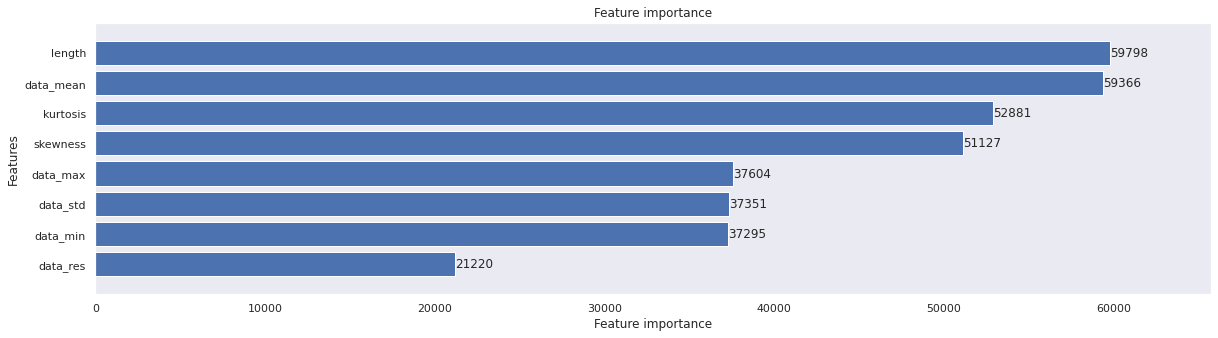

In [36]:
ax = lgb.plot_importance(clf, grid=False, height=0.8, figsize=(20,5))
plt.show()

**Pretty Table: Viewing Predictions**

In [37]:
def pred_to_labels(p, label):
  predictions = [list(np.argsort(p[i])[::-1][:3]) for i in range(len(p))]   # picking most appropriate labels
  prediction_label = []

  for pred in predictions:
    label_list =[]
    for output in pred:
      label_list.append(labels[output])
    prediction_label.append(label_list)
  return prediction_label

lab = pred_to_labels(p,labels)

t= PrettyTable(['Truth', 'Prediction'])
[t.add_row([labels[l[1][0]], l[0]]) for l in zip(lab[:10], actual[:10])]    # [1][0] is just to retriev first element as str, but not array 

for l in zip(lab[:10], actual[:10]):
  print(labels[l[1][0]], l[0])

print(t)   # printing table via PrettyTable


Fireworks ['Fireworks', 'Knock', 'Gunshot_or_gunfire']
Electric_piano ['Acoustic_guitar', 'Applause', 'Electric_piano']
Gong ['Applause', 'Gong', 'Acoustic_guitar']
Shatter ['Drawer_open_or_close', 'Knock', 'Shatter']
Drawer_open_or_close ['Shatter', 'Fireworks', 'Meow']
Gong ['Gong', 'Bark', 'Applause']
Saxophone ['Oboe', 'Double_bass', 'Saxophone']
Tearing ['Applause', 'Fireworks', 'Tearing']
Saxophone ['Saxophone', 'Trumpet', 'Bass_drum']
Applause ['Applause', 'Gong', 'Acoustic_guitar']
+----------------------+---------------------------------------------------+
|        Truth         |                     Prediction                    |
+----------------------+---------------------------------------------------+
|      Fireworks       |    ['Fireworks', 'Knock', 'Gunshot_or_gunfire']   |
|    Electric_piano    | ['Acoustic_guitar', 'Applause', 'Electric_piano'] |
|         Gong         |      ['Applause', 'Gong', 'Acoustic_guitar']      |
|       Shatter        |    ['Drawer_open_o

**Create Submission**

In [38]:
preds = clf.predict(X_test, num_iteration= clf.best_iteration)
lab = pred_to_labels(preds, labels) 

In [40]:
def create_submission(predictions, name='submission.csv'):
  predictions=['{}, {} ,{}'.format(x[0],x[1],x[2]) for x in predictions]
  submissions = pd.read_csv('/content/sample_submission.csv')
  submissions.label = predictions
  submissions.to_csv('{}'.format(name), index=False)
  print('Submission saved to {}'.format(name))

create_submission(lab)

Submission saved to submission.csv


In [42]:
! kaggle competitions submit -c freesound-audio-tagging -f submission.csv -m "Message"


100% 418k/418k [00:00<00:00, 1.71MB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge